# Исследование абонентов двух тарифов оператора сотовой связи

### Шаг 1. Откроем файлы с данными и изучим общую информацию.

In [1]:
from pymystem3 import Mystem
m = Mystem()
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls['call_date'].describe()

count         202607
unique           365
top       2018-12-31
freq            1435
Name: call_date, dtype: object

In [5]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [7]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
users = pd.read_csv('/datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Имеем пять таблиц, две из которых справочные (параметры тарифов и список клиентов), три отражают поведение клиентов по отдельным показателям: звонки, смс, интернет-серфинг. Больше всего записей в таблице звонков, что логично - более 200 тысяч; на втором месте использование интернета - 150 тыс. записей; в таблице сообщений записей еще меньше, но все равно больше 100 тыс. Интересно, что ID сообщений не упорядочены по дате отправки. Даты в таблицах требуют приведения к соответствующему формату. В названии столбца mg_per_month_included таблицы описания тарифов ошибка, данные по трафику и звонкам в соответствии с правилами компании нужно будет округлить. Много нулей в графе "длительность звонков", нужно попытаться выяснить, что не так с этими звонками. Может быть, человек не дозвонился. Кроме того, интересно изучить 38 ненулевых значений в графе "Дата прекращения пользования тарифом" - перешел человек на другой тариф в нашей компании или же сменил оператора. 

### Шаг 2. Предобработка данных

Сначала я бы хотел причесать данные в отдельных таблицах, чтобы в случае дальнейшего объединения у них были сохраненные данные правильного формата.

In [12]:
calls['date_call'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

In [13]:
calls.head(10)

,id,call_date,duration,user_id,date_call
0,1000_0,2018-07-25,0.00,1000,2018-07-25
1,1000_1,2018-08-17,0.00,1000,2018-08-17
2,1000_2,2018-06-11,2.85,1000,2018-06-11
3,1000_3,2018-09-21,13.80,1000,2018-09-21
4,1000_4,2018-12-15,5.18,1000,2018-12-15
5,1000_5,2018-11-02,0.00,1000,2018-11-02
6,1000_6,2018-10-18,0.00,1000,2018-10-18
7,1000_7,2018-08-22,18.31,1000,2018-08-22
8,1000_8,2018-09-15,18.44,1000,2018-09-15
9,1000_9,2018-08-15,0.00,1000,2018-08-15


In [14]:
calls['date_call'].describe()

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: date_call, dtype: object

In [15]:
calls = calls[['id', 'date_call', 'duration', 'user_id']]
calls.head()

,id,date_call,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Вот теперь все стало на места: наша выборка охватывает ровно один 2018 год.

In [16]:
internet['date_session'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')

In [17]:
internet.head()

,id,mb_used,session_date,user_id,date_session
0,1000_0,112.95,2018-11-25,1000,2018-11-25
1,1000_1,1052.81,2018-09-07,1000,2018-09-07
2,1000_2,1197.26,2018-06-25,1000,2018-06-25
3,1000_3,550.27,2018-08-22,1000,2018-08-22
4,1000_4,302.56,2018-09-24,1000,2018-09-24


In [18]:
internet['date_session'].describe()

count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: date_session, dtype: object

In [19]:
internet = internet[['id', 'mb_used', 'date_session', 'user_id']]
internet.head()

,id,mb_used,date_session,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [20]:
messages['date_message'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')

In [21]:
messages.head()

,id,message_date,user_id,date_message
0,1000_0,2018-06-27,1000,2018-06-27
1,1000_1,2018-10-08,1000,2018-10-08
2,1000_2,2018-08-04,1000,2018-08-04
3,1000_3,2018-06-16,1000,2018-06-16
4,1000_4,2018-12-05,1000,2018-12-05


In [22]:
messages['date_message'].describe()

count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: date_message, dtype: object

In [23]:
messages = messages[['id', 'date_message', 'user_id']]
messages.head()

,id,date_message,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [24]:
new_names = ['messages_included','mb_per_month_included','minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']
tariffs.set_axis(new_names, axis = 'columns',inplace = True)
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [25]:
calls['duration'] = np.ceil(calls['duration'])
calls.head()

,id,date_call,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


In [26]:
internet['mb_used'] = np.ceil(internet['mb_used'])
internet.head()

,id,mb_used,date_session,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000


In [27]:
users['registration_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,registration_date
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-25
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-17
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,2018-08-17
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018-05-14


In [28]:
users['out_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,registration_date,out_date
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-25,NaT
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01,NaT
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-17,NaT
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,2018-08-17,NaT
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018-05-14,NaT


In [29]:
users['out_date'].describe()

count                      38
unique                     33
top       2018-10-03 00:00:00
freq                        2
first     2018-08-17 00:00:00
last      2018-12-30 00:00:00
Name: out_date, dtype: object

In [30]:
users['registration_date'].describe()

count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: registration_date, dtype: object

In [31]:
users = users[['user_id', 'age', 'registration_date', 'out_date', 'city', 'first_name', 'last_name', 'tariff']]
users.head()

,user_id,age,registration_date,out_date,city,first_name,last_name,tariff
0,1000,52,2018-05-25,NaT,Краснодар,Рафаил,Верещагин,ultra
1,1001,41,2018-11-01,NaT,Москва,Иван,Ежов,smart
2,1002,59,2018-06-17,NaT,Стерлитамак,Евгений,Абрамович,smart
3,1003,23,2018-08-17,NaT,Москва,Белла,Белякова,ultra
4,1004,68,2018-05-14,NaT,Новокузнецк,Татьяна,Авдеенко,ultra


In [32]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
date_call    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [33]:
calls['duration'] = calls['duration'].astype('int')
calls.head()

,id,date_call,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


In [34]:
internet['mb_used'] = internet['mb_used'].astype('int')
internet.head()

,id,mb_used,date_session,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


In [35]:
percent_missing = calls.isnull().sum()*100 / len(calls)
missing_value_df = pd.DataFrame({'column_name': calls.columns, 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
id,id,0.0
date_call,date_call,0.0
duration,duration,0.0
user_id,user_id,0.0


In [36]:
calls.duplicated().sum()

0

In [37]:
internet.duplicated().sum()

0

In [38]:
messages.duplicated().sum()

0

In [39]:
calls[calls['duration'] == 0]['duration'].count()

39613

In [40]:
calls[calls['duration'] == 0]['duration'].count() *100 / len(calls)

19.551644316336553

Каждый пятый звонок не состоялся. Скорее всего, адресат просто не взял трубку. Все же посмотрим внимательнее.

In [41]:
calls[calls['duration'] == 0].head(10)

,id,date_call,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
5,1000_5,2018-11-02,0,1000
6,1000_6,2018-10-18,0,1000
9,1000_9,2018-08-15,0,1000
36,1000_36,2018-10-09,0,1000
38,1000_38,2018-05-25,0,1000
39,1000_39,2018-06-13,0,1000
40,1000_40,2018-10-25,0,1000
47,1000_47,2018-07-14,0,1000


In [42]:
calls[calls['duration'] == 0].tail(10)

,id,date_call,duration,user_id
202557,1499_170,2018-11-14,0,1499
202559,1499_172,2018-10-17,0,1499
202560,1499_173,2018-09-27,0,1499
202562,1499_175,2018-12-02,0,1499
202577,1499_190,2018-11-06,0,1499
202590,1499_203,2018-12-03,0,1499
202592,1499_205,2018-10-13,0,1499
202593,1499_206,2018-12-26,0,1499
202594,1499_207,2018-10-28,0,1499
202596,1499_209,2018-12-16,0,1499


In [43]:
len(calls[calls['duration'] == 0]['user_id'].unique())

492

Только 8 абонентов из 500 не знают, что такое не дозвониться. Если время звонка исчисляется с момента, когда адресат ответил на вызов, а нулевая продолжительность соответствует звонкам, когда адресат не ответил либо линия была занята, то сам по себе такой процент нулевых звонков не вызывает больших подозрений. Однако эти 8 строк тоже интересны.

In [44]:
users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

In [45]:
users = users.fillna(0)
users.head()

,user_id,age,registration_date,out_date,city,first_name,last_name,tariff
0,1000,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra
1,1001,41,2018-11-01,0,Москва,Иван,Ежов,smart
2,1002,59,2018-06-17,0,Стерлитамак,Евгений,Абрамович,smart
3,1003,23,2018-08-17,0,Москва,Белла,Белякова,ultra
4,1004,68,2018-05-14,0,Новокузнецк,Татьяна,Авдеенко,ultra


In [46]:
users[users['out_date'] != 0]

,user_id,age,registration_date,out_date,city,first_name,last_name,tariff
19,1019,63,2018-05-16,2018-10-05 00:00:00,Томск,Игнатий,Круглов,ultra
20,1020,59,2018-10-22,2018-12-18 00:00:00,Чита,Тала,Костина,smart
34,1034,66,2018-08-26,2018-11-21 00:00:00,Вологда,Святослав,Бондарев,smart
50,1050,44,2018-06-16,2018-10-03 00:00:00,Тюмень,Рузана,Аничкина,ultra
51,1051,37,2018-05-28,2018-10-14 00:00:00,Москва,Кристина,Сомова,smart
56,1056,73,2018-04-13,2018-10-14 00:00:00,Иркутск,Радислав,Артемьев,smart
62,1062,24,2018-11-16,2018-12-09 00:00:00,Москва,Александр,Коршунов,smart
63,1063,45,2018-04-12,2018-12-11 00:00:00,Тула,Таира,Климова,ultra
64,1064,55,2018-03-17,2018-12-26 00:00:00,Якутск,Динара,Алфеева,smart
65,1065,53,2018-03-08,2018-12-09 00:00:00,Москва,Роза,Игнатова,smart


In [47]:
users[users['out_date'] != 0]['out_date'].count()

38

In [48]:
len(users[users['out_date'] != 0]['last_name'].unique())

38

In [49]:
users_out = users[users['out_date'] != 0]['last_name'].unique()
users_out

array(['Круглов', 'Костина', 'Бондарев', 'Аничкина', 'Сомова', 'Артемьев',
       'Коршунов', 'Климова', 'Алфеева', 'Игнатова', 'Чумаков',
       'Астафьева', 'Агаева', 'Голованова', 'Вишневский', 'Акиндинов',
       'Веселов', 'Шарапова', 'Ларина', 'Федосеев', 'Сухарева',
       'Пономарева', 'Адамов', 'Чижова', 'Дубинина', 'Верещагина',
       'Анищенко', 'Абрикосова', 'Антоненко', 'Сысоев', 'Трофимов',
       'Беликова', 'Абрашина', 'Ёлчина', 'Устинова', 'Бородина',
       'Емельянова', 'Акимчин'], dtype=object)

In [50]:
users.loc[users['last_name'].isin(users_out)] 

,user_id,age,registration_date,out_date,city,first_name,last_name,tariff
19,1019,63,2018-05-16,2018-10-05 00:00:00,Томск,Игнатий,Круглов,ultra
20,1020,59,2018-10-22,2018-12-18 00:00:00,Чита,Тала,Костина,smart
34,1034,66,2018-08-26,2018-11-21 00:00:00,Вологда,Святослав,Бондарев,smart
50,1050,44,2018-06-16,2018-10-03 00:00:00,Тюмень,Рузана,Аничкина,ultra
51,1051,37,2018-05-28,2018-10-14 00:00:00,Москва,Кристина,Сомова,smart
56,1056,73,2018-04-13,2018-10-14 00:00:00,Иркутск,Радислав,Артемьев,smart
62,1062,24,2018-11-16,2018-12-09 00:00:00,Москва,Александр,Коршунов,smart
63,1063,45,2018-04-12,2018-12-11 00:00:00,Тула,Таира,Климова,ultra
64,1064,55,2018-03-17,2018-12-26 00:00:00,Якутск,Динара,Алфеева,smart
65,1065,53,2018-03-08,2018-12-09 00:00:00,Москва,Роза,Игнатова,smart


Похоже, что никто из абонентов не сменил один тариф на другой, они все просто перешли к другому оператору.

In [51]:
calls['month'] = calls['date_call'].dt.month
calls.head()

,id,date_call,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


In [52]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
date_call    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
month        202607 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.7+ MB


In [53]:
calls = calls.query('duration != 0')
calls.head()

,id,date_call,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9


In [54]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 5 columns):
id           162994 non-null object
date_call    162994 non-null datetime64[ns]
duration     162994 non-null int64
user_id      162994 non-null int64
month        162994 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.5+ MB


In [55]:
messages['month'] = messages['date_message'].dt.month
messages.head()

,id,date_message,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [56]:
internet['month'] = internet['date_session'].dt.month
internet.head()

,id,mb_used,date_session,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9


In [57]:
calls_df = calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum'])
calls_df

count  sum
user_id month            
1000    5         17  159
        6         28  172
        7         41  340
        8         42  408
        9         46  466
...              ...  ...
1498    10        30  247
1499    9          8   70
        10        44  449
        11        62  612
        12        56  492

[3168 rows x 2 columns]

Нулевые звонки из исходной таблицы можно удалить. А вот нули в месячных длительностях звонков, которые появятся при конкатенации, необходимо будет оставить.

In [58]:
message_df = messages.groupby(['user_id', 'month'])['id'].count()
message_df

user_id  month
1000     5        22
         6        60
         7        75
         8        81
         9        57
                  ..
1498     10       42
1499     9        11
         10       48
         11       59
         12       66
Name: id, Length: 2717, dtype: int64

In [59]:
internet_df = internet.groupby(['user_id', 'month'])['mb_used'].sum()
internet_df

user_id  month
1000     5         2256
         6        23257
         7        14016
         8        14070
         9        14581
                  ...  
1498     10       20604
1499     9         1848
         10       17809
         11       17984
         12       13077
Name: mb_used, Length: 3203, dtype: int64

In [60]:
len(calls['user_id'].unique())

492

In [61]:
those_who_called = calls['user_id'].unique()

In [62]:
users.query('user_id not in @those_who_called')

,user_id,age,registration_date,out_date,city,first_name,last_name,tariff
91,1091,36,2018-05-08,0,Набережные Челны,Вера,Суслова,ultra
106,1106,67,2018-04-26,0,Калуга,Исаак,Костин,ultra
128,1128,51,2018-12-15,2018-12-23 00:00:00,Волжский,Ксения,Агаева,ultra
231,1231,63,2018-05-23,0,Чебоксары,Касьян,Авдюков,ultra
328,1328,44,2018-10-16,0,Мурманск,Рауль,Аркадьев,ultra
371,1371,50,2018-12-25,2018-12-30 00:00:00,Омск,Ириней,Трофимов,smart
473,1473,18,2018-08-05,0,Красноярск,Николай,Лебедев,ultra
489,1489,35,2018-08-15,0,Санкт-Петербург,Павел,Гончаров,smart


Из восьми человек, попавших в выборку и не сделавших ни одного звонка за 2018 год, шестеро подключены к тарифу ultra. Возможно, это корпоративные сим-карты. Два из этих восьми абонентов покинули оператора в течение считанных дней. Строго говоря, никакой логики в том, что именно эти абоненты никуда не звонили, из имеющихся данных не вытащить. В любом случае даже в выборке из 500 человек это количество - полтора процента.

In [63]:
those_who_serfed = internet['user_id'].unique()
users.query('user_id not in @those_who_serfed')

,user_id,age,registration_date,out_date,city,first_name,last_name,tariff
128,1128,51,2018-12-15,2018-12-23 00:00:00,Волжский,Ксения,Агаева,ultra
273,1273,46,2018-05-15,0,Курган,Рэм,Корнилов,ultra
371,1371,50,2018-12-25,2018-12-30 00:00:00,Омск,Ириней,Трофимов,smart


А здесь все логично. Из трех абонентов, не воспользовавшихся интернетом в течение года, двое были нашими абонентами максимум неделю. Оставшийся абонент, вероятно, приобретал сим-карту для иных нужд.

In [64]:
those_who_sms = messages['user_id'].unique()
users.query('user_id not in @those_who_sms')

,user_id,age,registration_date,out_date,city,first_name,last_name,tariff
1,1001,41,2018-11-01,0,Москва,Иван,Ежов,smart
6,1006,21,2018-02-26,0,Ульяновск,Леонид,Ермолаев,smart
10,1010,26,2018-08-05,0,Тюмень,Эдуард,Кононов,smart
17,1017,73,2018-05-22,0,Краснодар,Мария,Аленникова,smart
24,1024,73,2018-10-31,0,Санкт-Петербург,Иулиан,Антипов,ultra
...,...,...,...,...,...,...,...,...
462,1462,72,2018-10-29,0,Тольятти,Алёна,Абрамычева,smart
466,1466,37,2018-02-28,0,Новосибирск,Рубен,Шевцов,ultra
469,1469,41,2018-07-06,0,Сочи,Аксён,Абалкин,ultra
479,1479,40,2018-07-03,0,Хабаровск,Игорь,Богданов,smart


Здесь никаких тенденций нет, кроме общей: смс-сообщениям, скорее всего, предпочитают мессенджеры, но в рамках нашей выборки этот тезис не проверить.

In [65]:
general_df = pd.concat([calls_df, message_df, internet_df], axis=1)
general_df = general_df.reset_index()
general_df.head()

,user_id,month,count,sum,id,mb_used
0,1000,5,17.0,159.0,22.0,2256.0
1,1000,6,28.0,172.0,60.0,23257.0
2,1000,7,41.0,340.0,75.0,14016.0
3,1000,8,42.0,408.0,81.0,14070.0
4,1000,9,46.0,466.0,57.0,14581.0


In [66]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id    3214 non-null int64
month      3214 non-null int64
count      3168 non-null float64
sum        3168 non-null float64
id         2717 non-null float64
mb_used    3203 non-null float64
dtypes: float64(4), int64(2)
memory usage: 150.8 KB


In [67]:
general_df = general_df.fillna(0)

In [68]:
general_df['count'] = general_df['count'].astype('int')
general_df['sum'] = general_df['sum'].astype('int')
general_df['id'] = general_df['id'].astype('int')
general_df['mb_used'] = general_df['mb_used'].astype('int')
general_df.head()

,user_id,month,count,sum,id,mb_used
0,1000,5,17,159,22,2256
1,1000,6,28,172,60,23257
2,1000,7,41,340,75,14016
3,1000,8,42,408,81,14070
4,1000,9,46,466,57,14581


In [69]:
general_df = general_df.merge(users, on='user_id', how='left')
general_df.head()

,user_id,month,count,sum,id,mb_used,age,registration_date,out_date,city,first_name,last_name,tariff
0,1000,5,17,159,22,2256,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra
1,1000,6,28,172,60,23257,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra
2,1000,7,41,340,75,14016,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra
3,1000,8,42,408,81,14070,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra
4,1000,9,46,466,57,14581,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra


In [70]:
general_df = general_df.merge(tariffs, on='tariff', how='left')
general_df.head()

,user_id,month,count,sum,id,mb_used,age,registration_date,out_date,city,first_name,last_name,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,17,159,22,2256,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,28,172,60,23257,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,41,340,75,14016,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,42,408,81,14070,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,46,466,57,14581,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra,1000,30720,3000,1950,150,1,1


In [71]:
general_df.columns

Index(['user_id', 'month', 'count', 'sum', 'id', 'mb_used', 'age',
       'registration_date', 'out_date', 'city', 'first_name', 'last_name',
       'tariff', 'messages_included', 'mb_per_month_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute'],
      dtype='object')

In [72]:
general_df = general_df[['user_id', 'month', 'count', 'sum', 'id', 'mb_used', 'city', 'tariff', 'messages_included', 'mb_per_month_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute']]
general_df.head()

,user_id,month,count,sum,id,mb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,17,159,22,2256,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,28,172,60,23257,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,41,340,75,14016,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,42,408,81,14070,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,46,466,57,14581,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [73]:
column_names=['user_id', 'Месяц', 'Число звонков', 'Длит. звонков', 'СМС', 'Интернет', 'Город', 'Тариф', 'Лимит СМС', 
        'Лимит Мб', 'Лимит мин', 'Аб.плата', 'Цена Гб', 'Цена СМС', 'Цена мин']

In [74]:
general_df.set_axis(column_names, axis = 'columns',inplace = True)
general_df.head()

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Лимит СМС,Лимит Мб,Лимит мин,Аб.плата,Цена Гб,Цена СМС,Цена мин
0,1000,5,17,159,22,2256,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,28,172,60,23257,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,41,340,75,14016,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,42,408,81,14070,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,46,466,57,14581,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [75]:
def uplimit(df, column, sum_column, lim_column):
    def uplimit_delta(row):
        if row[sum_column] <= row[lim_column]:
            return 0
        else:
            return row[sum_column]-row[lim_column]
    df[column] = df.apply(uplimit_delta, axis=1)

На этом этапе нужно добавить в таблицу несколько однотипных столбцов, в которых будут подсчитаны превышения тарифных лимитов по звонкам, смс и трафику. Это лучше сделать функцией, вложенной в другую функцию. Внутренняя работает со столбцами "Лимит" и "Сумма": проверяет, превышен ли лимит, и если да, то возвращает разницу, а если нет, то ноль. Внешняя же добавляет в таблицу новый столбец, который заполняет значениями, полученными во внутренней функции.

In [76]:
uplimit(general_df, 'Мин сверх лимита', 'Длит. звонков', 'Лимит мин')
general_df.head()

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Лимит СМС,Лимит Мб,Лимит мин,Аб.плата,Цена Гб,Цена СМС,Цена мин,Мин сверх лимита
0,1000,5,17,159,22,2256,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0
1,1000,6,28,172,60,23257,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0
2,1000,7,41,340,75,14016,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0
3,1000,8,42,408,81,14070,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0
4,1000,9,46,466,57,14581,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0


In [77]:
uplimit(general_df, 'Мб сверх лимита', 'Интернет', 'Лимит Мб')
general_df.head()

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Лимит СМС,Лимит Мб,Лимит мин,Аб.плата,Цена Гб,Цена СМС,Цена мин,Мин сверх лимита,Мб сверх лимита
0,1000,5,17,159,22,2256,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0
1,1000,6,28,172,60,23257,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0
2,1000,7,41,340,75,14016,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0
3,1000,8,42,408,81,14070,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0
4,1000,9,46,466,57,14581,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0


In [78]:
uplimit(general_df, 'СМС сверх лимита', 'СМС', 'Лимит СМС')
general_df.head()

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Лимит СМС,Лимит Мб,Лимит мин,Аб.плата,Цена Гб,Цена СМС,Цена мин,Мин сверх лимита,Мб сверх лимита,СМС сверх лимита
0,1000,5,17,159,22,2256,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0
1,1000,6,28,172,60,23257,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0
2,1000,7,41,340,75,14016,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0
3,1000,8,42,408,81,14070,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0
4,1000,9,46,466,57,14581,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0


In [79]:
general_df['Плата сверх'] = (
    general_df['Мин сверх лимита']*general_df['Цена мин']
    + np.round((general_df['Мб сверх лимита']*general_df['Цена Гб'] / 1024), 2)
    + general_df['СМС сверх лимита']*general_df['Цена СМС']
)

In [80]:
general_df.head()

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Лимит СМС,Лимит Мб,Лимит мин,Аб.плата,Цена Гб,Цена СМС,Цена мин,Мин сверх лимита,Мб сверх лимита,СМС сверх лимита,Плата сверх
0,1000,5,17,159,22,2256,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,0.0
1,1000,6,28,172,60,23257,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,0.0
2,1000,7,41,340,75,14016,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,0.0
3,1000,8,42,408,81,14070,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,0.0
4,1000,9,46,466,57,14581,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,0.0


In [81]:
general_df[general_df['Плата сверх'] > 0]

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Лимит СМС,Лимит Мб,Лимит мин,Аб.плата,Цена Гб,Цена СМС,Цена мин,Мин сверх лимита,Мб сверх лимита,СМС сверх лимита,Плата сверх
8,1001,11,45,430,0,18452,Москва,smart,50,15360,500,550,200,3,3,0,3092,0,603.91
11,1002,7,21,214,11,17601,Стерлитамак,smart,50,15360,500,550,200,3,3,0,2241,0,437.70
12,1002,8,37,289,13,20347,Стерлитамак,smart,50,15360,500,550,200,3,3,0,4987,0,974.02
13,1002,9,25,206,4,16712,Стерлитамак,smart,50,15360,500,550,200,3,3,0,1352,0,264.06
15,1002,11,25,243,16,18610,Стерлитамак,smart,50,15360,500,550,200,3,3,0,3250,0,634.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,1498,9,53,471,44,22166,Владикавказ,smart,50,15360,500,550,200,3,3,0,6806,0,1329.30
3209,1498,10,30,247,42,20604,Владикавказ,smart,50,15360,500,550,200,3,3,0,5244,0,1024.22
3211,1499,10,44,449,48,17809,Пермь,smart,50,15360,500,550,200,3,3,0,2449,0,478.32
3212,1499,11,62,612,59,17984,Пермь,smart,50,15360,500,550,200,3,3,112,2624,9,875.50


In [82]:
general_df['Сумма за мес'] = general_df['Аб.плата'] + general_df['Плата сверх']
general_df.head()

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Лимит СМС,Лимит Мб,Лимит мин,Аб.плата,Цена Гб,Цена СМС,Цена мин,Мин сверх лимита,Мб сверх лимита,СМС сверх лимита,Плата сверх,Сумма за мес
0,1000,5,17,159,22,2256,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,0.0,1950.0
1,1000,6,28,172,60,23257,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,0.0,1950.0
2,1000,7,41,340,75,14016,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,0.0,1950.0
3,1000,8,42,408,81,14070,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,0.0,1950.0
4,1000,9,46,466,57,14581,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,0.0,1950.0


In [83]:
main_df = general_df[['user_id', 'Месяц', 'Число звонков', 'Длит. звонков', 'СМС', 'Интернет',
       'Город', 'Тариф', 'Аб.плата', 'Мин сверх лимита',
       'Мб сверх лимита', 'СМС сверх лимита', 'Плата сверх', 'Сумма за мес']]
main_df.head()

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Аб.плата,Мин сверх лимита,Мб сверх лимита,СМС сверх лимита,Плата сверх,Сумма за мес
0,1000,5,17,159,22,2256,Краснодар,ultra,1950,0,0,0,0.0,1950.0
1,1000,6,28,172,60,23257,Краснодар,ultra,1950,0,0,0,0.0,1950.0
2,1000,7,41,340,75,14016,Краснодар,ultra,1950,0,0,0,0.0,1950.0
3,1000,8,42,408,81,14070,Краснодар,ultra,1950,0,0,0,0.0,1950.0
4,1000,9,46,466,57,14581,Краснодар,ultra,1950,0,0,0,0.0,1950.0


In [84]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
user_id             3214 non-null int64
Месяц               3214 non-null int64
Число звонков       3214 non-null int64
Длит. звонков       3214 non-null int64
СМС                 3214 non-null int64
Интернет            3214 non-null int64
Город               3214 non-null object
Тариф               3214 non-null object
Аб.плата            3214 non-null int64
Мин сверх лимита    3214 non-null int64
Мб сверх лимита     3214 non-null int64
СМС сверх лимита    3214 non-null int64
Плата сверх         3214 non-null float64
Сумма за мес        3214 non-null float64
dtypes: float64(2), int64(10), object(2)
memory usage: 376.6+ KB


На этом этапе получена сводная таблица, в которой ненулевые данные сгруппированы помесячно и по id абонента. В дальнейшем анализе нам не важны персональные данные абонентов, важен только регион проживания и тариф - эти данные оставлены. В таблице видны перерасходы минут, смс и Мб интернета (если таковые есть), а также сколько пришлось в сумме переплатить абоненту сверх абонентской платы и итоговую сумму, которую принес абонент за месяц.

### Шаг 3. Анализ данных

In [85]:
users.head()

,user_id,age,registration_date,out_date,city,first_name,last_name,tariff
0,1000,52,2018-05-25,0,Краснодар,Рафаил,Верещагин,ultra
1,1001,41,2018-11-01,0,Москва,Иван,Ежов,smart
2,1002,59,2018-06-17,0,Стерлитамак,Евгений,Абрамович,smart
3,1003,23,2018-08-17,0,Москва,Белла,Белякова,ultra
4,1004,68,2018-05-14,0,Новокузнецк,Татьяна,Авдеенко,ultra


In [86]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id              500 non-null int64
age                  500 non-null int64
registration_date    500 non-null datetime64[ns]
out_date             500 non-null object
city                 500 non-null object
first_name           500 non-null object
last_name            500 non-null object
tariff               500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [87]:
users[users['tariff'] == 'ultra']['tariff'].count()

149

In [88]:
users[users['tariff'] == 'smart']['tariff'].count()

351

Пользователей тарифа Ультра - 149 человек, Смарт - 351 человек

In [89]:
calls_mean_ultra = main_df[main_df['Тариф'] == 'ultra']['Длит. звонков'].mean()
calls_mean_ultra

526.6233502538071

In [90]:
calls_mean_smart = main_df[main_df['Тариф'] == 'smart']['Длит. звонков'].mean()
calls_mean_smart

417.9349484073576

In [91]:
sms_mean_ultra = main_df[main_df['Тариф'] == 'ultra']['СМС'].mean()
sms_mean_ultra

49.36345177664975

In [92]:
sms_mean_smart = main_df[main_df['Тариф'] == 'smart']['СМС'].mean()
sms_mean_smart

33.384028712427096

In [93]:
inet_mean_ultra = main_df[main_df['Тариф'] == 'ultra']['Интернет'].mean()
inet_mean_ultra

19486.90152284264

In [94]:
inet_mean_smart = main_df[main_df['Тариф'] == 'smart']['Интернет'].mean()
inet_mean_smart

16229.188425302826

In [95]:
var_calls_ultra = np.var(main_df[main_df['Тариф'] == 'ultra']['Длит. звонков'], ddof=1)
var_calls_ultra

100873.63339730098

In [96]:
var_calls_smart = np.var(main_df[main_df['Тариф'] == 'smart']['Длит. звонков'], ddof=1)
var_calls_smart

36219.31578434428

In [97]:
std_calls_ultra = np.std(main_df[main_df['Тариф'] == 'ultra']['Длит. звонков'], ddof=1)
std_calls_ultra

317.6060978591264

In [98]:
std_calls_smart = np.std(main_df[main_df['Тариф'] == 'smart']['Длит. звонков'], ddof=1)
std_calls_smart

190.31372988921288

In [99]:
var_sms_ultra = np.var(main_df[main_df['Тариф'] == 'ultra']['СМС'], ddof=1)
var_sms_ultra

2285.266142544674

In [100]:
var_sms_smart = np.var(main_df[main_df['Тариф'] == 'smart']['СМС'], ddof=1)
var_sms_smart

796.8129584480083

In [101]:
std_sms_ultra = np.std(main_df[main_df['Тариф'] == 'ultra']['СМС'], ddof=1)
std_sms_ultra

47.80445735017472

In [102]:
std_sms_smart = np.std(main_df[main_df['Тариф'] == 'smart']['СМС'], ddof=1)
std_sms_smart

28.22787555676141

In [103]:
var_inet_ultra = np.var(main_df[main_df['Тариф'] == 'ultra']['Интернет'], ddof=1)
var_inet_ultra

101935621.04821923

In [104]:
var_inet_smart = np.var(main_df[main_df['Тариф'] == 'smart']['Интернет'], ddof=1)
var_inet_smart

34545911.12695753

In [105]:
std_inet_ultra = np.std(main_df[main_df['Тариф'] == 'ultra']['Интернет'], ddof=1)
std_inet_ultra

10096.317202238608

In [106]:
std_inet_smart = np.std(main_df[main_df['Тариф'] == 'smart']['Интернет'], ddof=1)
std_inet_smart

5877.576977544193

In [107]:
var_std_columns = ['Тариф', 'Средняя дл-ть звонков', 'Дисперсия звонков', 'СТД звонков', 'Среднее число СМС', 'Дисперсия СМС', 'СТД СМС', 'Средний трафик', 'Дисперсия интернета', 'СТД интернета']
var_std_data = [
    ['ultra', calls_mean_ultra, var_calls_ultra, std_calls_ultra, sms_mean_ultra, var_sms_ultra, std_sms_ultra, inet_mean_ultra, var_inet_ultra, std_inet_ultra],
    ['smart', calls_mean_smart, var_calls_smart, std_calls_smart, sms_mean_smart, var_sms_smart, std_sms_smart, inet_mean_smart, var_inet_smart, std_inet_smart]
]
var_std = pd.DataFrame(data=var_std_data, columns=var_std_columns)
var_std

,Тариф,Средняя дл-ть звонков,Дисперсия звонков,СТД звонков,Среднее число СМС,Дисперсия СМС,СТД СМС,Средний трафик,Дисперсия интернета,СТД интернета
0,ultra,526.623350,100873.633397,317.606098,49.363452,2285.266143,47.804457,19486.901523,1.019356e+08,10096.317202
1,smart,417.934948,36219.315784,190.313730,33.384029,796.812958,28.227876,16229.188425,3.454591e+07,5877.576978


In [108]:
main_df.head()

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Аб.плата,Мин сверх лимита,Мб сверх лимита,СМС сверх лимита,Плата сверх,Сумма за мес
0,1000,5,17,159,22,2256,Краснодар,ultra,1950,0,0,0,0.0,1950.0
1,1000,6,28,172,60,23257,Краснодар,ultra,1950,0,0,0,0.0,1950.0
2,1000,7,41,340,75,14016,Краснодар,ultra,1950,0,0,0,0.0,1950.0
3,1000,8,42,408,81,14070,Краснодар,ultra,1950,0,0,0,0.0,1950.0
4,1000,9,46,466,57,14581,Краснодар,ultra,1950,0,0,0,0.0,1950.0


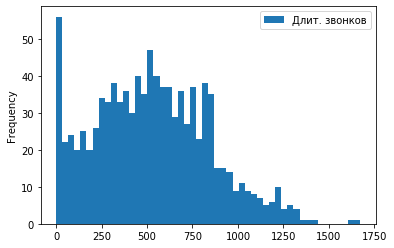

In [109]:
main_df[main_df['Тариф'] == 'ultra'].plot(y='Длит. звонков', kind='hist', bins=50)

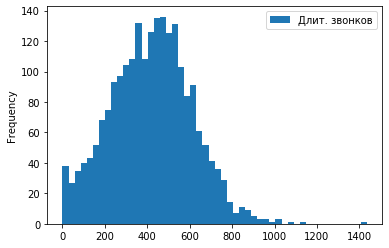

In [110]:
main_df[main_df['Тариф'] == 'smart'].plot(y='Длит. звонков', kind='hist', bins=50)

Нулевая месячная длительность звонков - явно аномалия. Скорее всего, это пользователи, подключившиеся в конце месяца и не успевшие до его конца сделать исходящие звонки. И там, и там есть выбросы - среди пользователей ultra это месячная длительность звонков в 1600 минут, а среди абонентов smart - чуть больше 1400 минут.

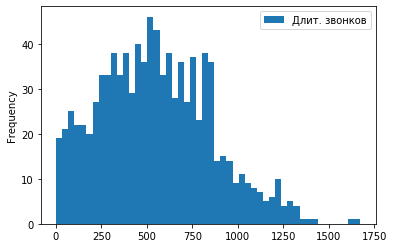

In [111]:
main_df[(main_df['Тариф'] == 'ultra') & (main_df['Длит. звонков'] != 0)].plot(y='Длит. звонков', kind='hist', bins=50)

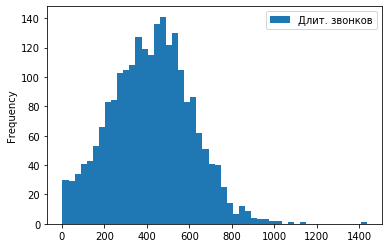

In [112]:
main_df[(main_df['Тариф'] == 'smart') & (main_df['Длит. звонков'] != 0)].plot(y='Длит. звонков', kind='hist', bins=50)

Распределение длительности звонков для абонентов smart очень похоже на нормальное со средним около 417 мин. Для абонентов ultra распределение тоже похоже на нормальное, но в меньшей степени. Скорее всего это связано с тем, что по этому тарифу меньше абонентов попало в выборку.

In [113]:
boxlist1 = ['Длит. звонков', 'СМС', 'Интернет']

Длит. звонков       AxesSubplot(0.125,0.125;0.227941x0.755)
СМС              AxesSubplot(0.398529,0.125;0.227941x0.755)
Интернет         AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

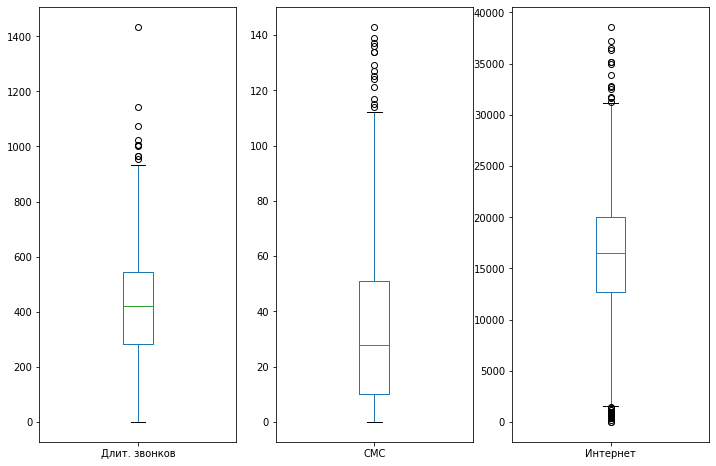

In [114]:
main_df[main_df['Тариф'] == 'smart'][boxlist1].plot(kind='box', subplots=True, layout=(1, 3), figsize=(12,8))

Длит. звонков       AxesSubplot(0.125,0.125;0.227941x0.755)
СМС              AxesSubplot(0.398529,0.125;0.227941x0.755)
Интернет         AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

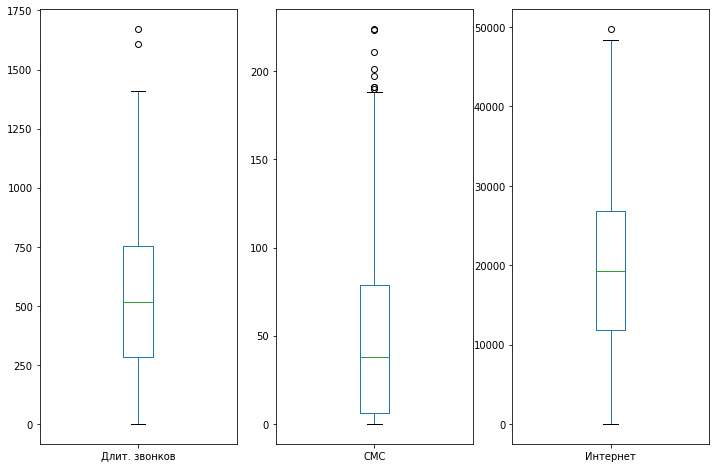

In [115]:
main_df[main_df['Тариф'] == 'ultra'][boxlist1].plot(kind='box', subplots=True, layout=(1, 3), figsize=(12,8))

В разбивке на тарифы видно, что "выбросов" в бОльшую сторону не слишком много. В то же время совсем удалять их из исследования нецелесообразно.

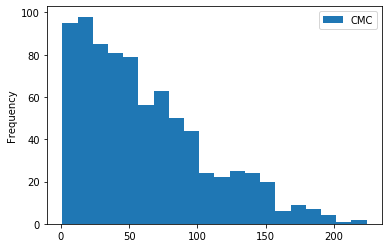

In [116]:
main_df[(main_df['Тариф'] == 'ultra') & (main_df['СМС'] != 0)].plot(y='СМС', kind='hist', bins=20)

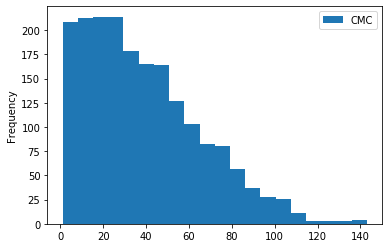

In [117]:
main_df[(main_df['Тариф'] == 'smart') & (main_df['СМС'] != 0)].plot(y='СМС', kind='hist', bins=20)

Для обоих тарифов статистика СМС похожа на нормальное распределение, сильно скошенное вправо. 

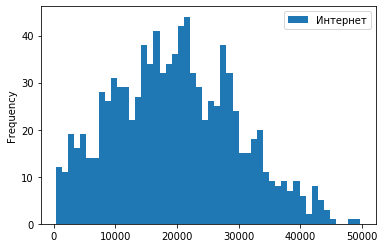

In [118]:
main_df[(main_df['Тариф'] == 'ultra') & (main_df['Интернет'] != 0)].plot(y='Интернет', kind='hist', bins=50)

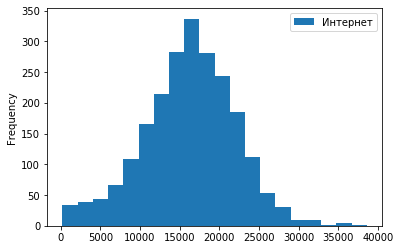

In [119]:
main_df[(main_df['Тариф'] == 'smart') & (main_df['Интернет'] != 0)].plot(y='Интернет', kind='hist', bins=20)

И снова для smart статистика более похожа на нормальное распределение. 

Text(0, 0.5, '')

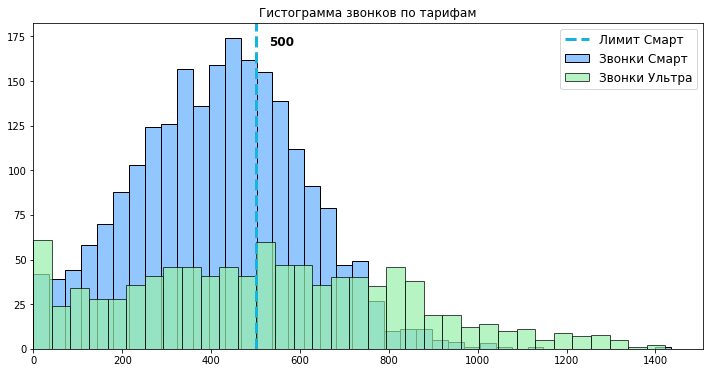

In [120]:
ax = plt.gca()
column = 'Длит. звонков'
lim_column = 'Лимит мин'
title = 'Гистограмма звонков по тарифам'
main_df[main_df['Тариф'] == 'smart'][column].plot(kind='hist', bins=40, figsize=(12,6), 
                                                                    ec='black', ax=ax, color='#92c6ff', 
                                                                    title=title, xlim=0)
main_df[main_df['Тариф'] == 'ultra'][column].plot(kind='hist', bins=40, figsize=(12,6), 
                                                                    ec='black', ax=ax, color='#97F0AA', 
                                                                    title=title, xlim=0, alpha=0.7)

plt.axvline(x=500,
            linewidth=3, color='#16B4DC', linestyle='--')
ax.text(500+30, 170, 500,fontweight='bold', fontsize='large')


#plt.axvline(x=3000,
#            linewidth=3, color='#35B815', linestyle='--')
#ax.text(main_df[main_df['Тариф'] == 'ultra'][lim_column].median()+7, 170, 
#        '{0:.0f}'.format(main_df[main_df['Тариф'] == 'ultra'][lim_column].median()), 
#        fontweight='bold', fontsize='large')

plt.legend(['Лимит Смарт', 'Звонки Смарт', 'Звонки Ультра'], prop={'size':12})
ax.set_ylabel('')

Никто не превышал лимит звонков по тарифу "Ультра", даже половину отпущенного тарифом объема выговаривают считанные единицы абонентов. А вот абоненты "Смарта" регулярно превышают лимит. Здесь, кстати, интересно посмотреть, есть ли среди абонентов "Смарта" такие, кто превышает свои лимиты и платит в сумме больше, чем лимит по "Ультра". Запомним этот вопрос, а пока подсчитаем, сколько пользователей "Смарта" грешат перерасходами.

In [121]:
main_df.head()

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Аб.плата,Мин сверх лимита,Мб сверх лимита,СМС сверх лимита,Плата сверх,Сумма за мес
0,1000,5,17,159,22,2256,Краснодар,ultra,1950,0,0,0,0.0,1950.0
1,1000,6,28,172,60,23257,Краснодар,ultra,1950,0,0,0,0.0,1950.0
2,1000,7,41,340,75,14016,Краснодар,ultra,1950,0,0,0,0.0,1950.0
3,1000,8,42,408,81,14070,Краснодар,ultra,1950,0,0,0,0.0,1950.0
4,1000,9,46,466,57,14581,Краснодар,ultra,1950,0,0,0,0.0,1950.0


In [122]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
user_id             3214 non-null int64
Месяц               3214 non-null int64
Число звонков       3214 non-null int64
Длит. звонков       3214 non-null int64
СМС                 3214 non-null int64
Интернет            3214 non-null int64
Город               3214 non-null object
Тариф               3214 non-null object
Аб.плата            3214 non-null int64
Мин сверх лимита    3214 non-null int64
Мб сверх лимита     3214 non-null int64
СМС сверх лимита    3214 non-null int64
Плата сверх         3214 non-null float64
Сумма за мес        3214 non-null float64
dtypes: float64(2), int64(10), object(2)
memory usage: 376.6+ KB


In [123]:
len(main_df[(main_df['Тариф'] == 'smart') & (main_df['Мин сверх лимита'] > 0)]['user_id'].unique())

213

Из 351 абонента "Смарта" 213 человек попались на перерасходе.

In [124]:
smart_extra = main_df[(main_df['Тариф'] == 'smart') & (main_df['Мин сверх лимита'] > 0) & (main_df['Сумма за мес'] > 1950)]
smart_extra

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Аб.плата,Мин сверх лимита,Мб сверх лимита,СМС сверх лимита,Плата сверх,Сумма за мес
86,1011,11,52,501,12,25332,Самара,smart,550,1,9972,0,1950.66,2500.66
157,1023,12,67,557,49,28422,Томск,smart,550,57,13062,0,2722.17,3272.17
175,1027,5,67,623,22,24905,Петрозаводск,smart,550,123,9545,0,2233.26,2783.26
187,1029,10,74,609,62,21589,Екатеринбург,smart,550,109,6229,12,1579.60,2129.60
258,1041,12,102,861,26,23146,Москва,smart,550,361,7786,0,2603.70,3153.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,1496,2,65,594,45,28523,Вологда,smart,550,94,13163,0,2852.90,3402.90
3193,1496,3,67,557,46,24990,Вологда,smart,550,57,9630,0,2051.86,2601.86
3197,1496,7,63,582,42,24395,Вологда,smart,550,82,9035,0,2010.65,2560.65
3198,1496,8,62,527,41,23560,Вологда,smart,550,27,8200,0,1682.56,2232.56


In [125]:
len(smart_extra['user_id'].unique())

100

Ровно сто абонентов "Смарта" имеют опыт месячных расходов по тарифу, превышающих даже абонентскую плату "Ультра". Выше мы уже видели, что никто во всей выборке не превысил лимит по минутам разговора, установленный для "Ультры". Посмотрим, сколько абонентов "Смарта" из сильно переплачивающих по своему тарифу устроил бы тариф "Ультра".

In [126]:
len(smart_extra.query('СМС > 1000 or Интернет < 30720')['user_id'].unique())

94

94 абонента "Смарта" вполне вписались бы в лимиты "Ультра" и еще шестеро не вписались бы даже в них. Статистика интересная, но это вопрос, скорее, к абонентам, которые нерационально расходуют свои средства. А вот оператор благодаря этим абонентам получает выручку больше ожидаемой - так как это касается 27% абонентов "Смарта", такой фактор нужно признать существенным.

In [127]:
ultra_extra = main_df[(main_df['Тариф'] == 'ultra') & (main_df['Плата сверх'] > 0)]
ultra_extra

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Аб.плата,Мин сверх лимита,Мб сверх лимита,СМС сверх лимита,Плата сверх,Сумма за мес
159,1024,11,127,1146,0,43146,Санкт-Петербург,ultra,1950,0,12426,0,1820.21,3770.21
160,1024,12,108,949,0,35985,Санкт-Петербург,ultra,1950,0,5265,0,771.24,2721.24
311,1050,7,26,209,52,35205,Тюмень,ultra,1950,0,4485,0,656.98,2606.98
383,1060,12,144,1233,52,43973,Калуга,ultra,1950,0,13253,0,1941.36,3891.36
799,1124,10,130,1225,121,49789,Махачкала,ultra,1950,0,19069,0,2793.31,4743.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,1469,11,88,795,0,35533,Сочи,ultra,1950,0,4813,0,705.03,2655.03
3051,1474,12,132,1345,105,42356,Набережные Челны,ultra,1950,0,11636,0,1704.49,3654.49
3180,1493,12,69,571,78,42776,Красноярск,ultra,1950,0,12056,0,1766.02,3716.02
3187,1495,9,95,813,82,33105,Иркутск,ultra,1950,0,2385,0,349.37,2299.37


In [128]:
len(ultra_extra['user_id'].unique())

43

А вот из абонентов "Ультра" переплачивают только 43 человека. Со звонками это не связано точно; вряд ли это связано с перерасходом СМС - скорее всего, перерасход по трафику.

In [129]:
len(main_df[(main_df['Тариф'] == 'ultra') & (main_df['СМС сверх лимита'] > 0)]['user_id'].unique())

0

Да, только интернет. Интересно, предусмотрена ли условиями тарифа возможность раздавать интернет на другие устройства. Если да, то перерасход выглядит логично.

In [130]:
ultra_extra.groupby(['Месяц'])['Мб сверх лимита'].agg('mean')

Месяц
2     1888.000000
3     2736.600000
4     3411.600000
5     8001.666667
6     5228.555556
7     7033.285714
8     5205.647059
9     3573.500000
10    5281.000000
11    5697.142857
12    6968.375000
Name: Мб сверх лимита, dtype: float64

Интересно, что в январе ни у одного абонента "Ультра" не было перерасхода по трафику, а затем он составляет в среднем от 3 до 8 Гб. 43 абонента - это примерно 29% от общего числа абонентов "Ультра". 

In [131]:
len(main_df[(main_df['Тариф'] == 'smart') & (main_df['Плата сверх'] > 0)]['user_id'].unique())

333

Итак. 95% абонентов "Смарта" регулярно переплачивают за связь. 28% абонентов "Смарта" переплачивали бы даже будучи пользователями "Ультра". И 29% абонентов "Ультры" переплачиывают сверх своего тарифа.

### Шаг 4. Проверка гипотез

Гипотеза 0: средняя выручка тарифов "Ультра" и "Смарт" одинакова.
Альтернативная гипотеза Н1: средняя выручка тарифов "Ультра" и "Смарт" отличается.

In [132]:
main_df.head()

,user_id,Месяц,Число звонков,Длит. звонков,СМС,Интернет,Город,Тариф,Аб.плата,Мин сверх лимита,Мб сверх лимита,СМС сверх лимита,Плата сверх,Сумма за мес
0,1000,5,17,159,22,2256,Краснодар,ultra,1950,0,0,0,0.0,1950.0
1,1000,6,28,172,60,23257,Краснодар,ultra,1950,0,0,0,0.0,1950.0
2,1000,7,41,340,75,14016,Краснодар,ultra,1950,0,0,0,0.0,1950.0
3,1000,8,42,408,81,14070,Краснодар,ultra,1950,0,0,0,0.0,1950.0
4,1000,9,46,466,57,14581,Краснодар,ultra,1950,0,0,0,0.0,1950.0


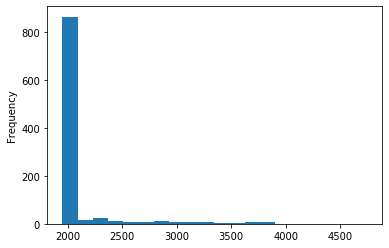

In [133]:
main_df[main_df['Тариф'] == 'ultra']['Сумма за мес'].plot(y='Сумма за мес', kind='hist', bins=20)

Text(0, 0.5, '')

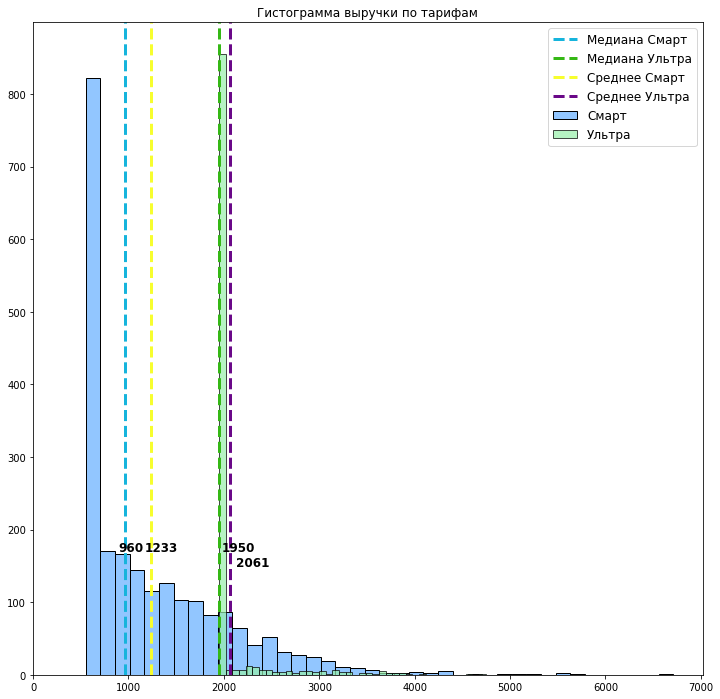

In [134]:
ax = plt.gca()
column = 'Сумма за мес'
title = 'Гистограмма выручки по тарифам'
main_df[main_df['Тариф'] == 'smart'][column].plot(kind='hist', bins=40, figsize=(12,12), 
                                                                    ec='black', ax=ax, color='#92c6ff', 
                                                                    title=title, xlim=0)
main_df[main_df['Тариф'] == 'ultra'][column].plot(kind='hist', bins=40, figsize=(12,12), 
                                                                    ec='black', ax=ax, color='#97F0AA', 
                                                                    title=title, xlim=0, alpha=0.7)
plt.axvline(x=main_df[main_df['Тариф'] == 'smart'][column].median(),
            linewidth=3, color='#16B4DC', linestyle='--')
ax.text(main_df[main_df['Тариф'] == 'smart'][column].median()-65, 170, 
        '{0:.0f}'.format(main_df[main_df['Тариф'] == 'smart'][column].median()), 
        fontweight='bold', fontsize='large')
plt.axvline(x=main_df[main_df['Тариф'] == 'ultra'][column].median(),
            linewidth=3, color='#35B815', linestyle='--')
ax.text(main_df[main_df['Тариф'] == 'ultra'][column].median()+27, 170, 
        '{0:.0f}'.format(main_df[main_df['Тариф'] == 'ultra'][column].median()), 
        fontweight='bold', fontsize='large')

plt.axvline(x=main_df[main_df['Тариф'] == 'smart'][column].mean(),
            linewidth=3, color='#F7FE2E', linestyle='--')
ax.text(main_df[main_df['Тариф'] == 'smart'][column].mean()-65, 170, 
        '{0:.0f}'.format(main_df[main_df['Тариф'] == 'smart'][column].mean()), 
        fontweight='bold', fontsize='large')

plt.axvline(x=main_df[main_df['Тариф'] == 'ultra'][column].mean(),
            linewidth=3, color='#6A0888', linestyle='--')
ax.text(main_df[main_df['Тариф'] == 'ultra'][column].mean()+67, 150, 
        '{0:.0f}'.format(main_df[main_df['Тариф'] == 'ultra'][column].mean()), 
        fontweight='bold', fontsize='large')

plt.legend(['Медиана Смарт', 'Медиана Ультра', 'Среднее Смарт', 'Среднее Ультра', 'Смарт', 'Ультра'], prop={'size':12})
ax.set_ylabel('')

In [135]:
alpha = .01
results = st.ttest_ind(
    main_df[main_df['Тариф'] == 'smart']['Сумма за мес'], 
    main_df[main_df['Тариф'] == 'ultra']['Сумма за мес']
)
print('p-значение', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение 1.1725472632487766e-190
Отвергаем нулевую гипотезу


Даже если установить пороговое значение как 1%, вероятность получить наблюдаемый результат при условии верности нулевой гипотезы слишком мала, поэтому мы ее отвергаем. Стало быть, выручка от разных тарифов отличается.

Гипотеза 0: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов. Альтернативная гипотеза Н1: эти выручки отличаются.

In [136]:
alpha = .05
results_region = st.ttest_ind(
    main_df[main_df['Город'] == 'Москва']['Сумма за мес'], 
    main_df[main_df['Город'] != 'Москва']['Сумма за мес']
)
print('p-значение', results_region.pvalue)
if (results_region.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение 0.4744327296711197
Не получилось отвергнуть нулевую гипотезу


А вот географические параметры не имеют статистически важного значения. Вероятность получить наблюдаемое соотношение при условии правильности нулевой гипотезы почти 50%, поэтому исходя из имеющихся данных эту гипотезу отвергнуть нельзя.

### Выводы

Проанализировав исходные данные, свели в общую таблицу статистику по продолжительности звонков, числу отправленных СМС и объему использованного трафика для обоих тарифов помесячно. Рассчитали средние значения, дисперсии и стандартные отклонения по каждому параметру в зависимости от тарифа. Проверили статистически гипотезу о неравенстве средней выручки с тарифов "Ультра" и "Смарт": получили, что в случае равенства средней выручки с этих двух тарифов вероятность получить имеющиеся в распоряжении выборки слишком мала и стремится к нулю. Напротив, не обнаружилось оснований полагать, что выручка от московских абонентов статистически значимо отличается от выручки абонентов из других регионов.